<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données et librairies**



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import TimeDistributed
from keras.layers import Conv3D, Conv2D,BatchNormalization,MaxPooling2D , MaxPooling3D, GlobalMaxPool2D,GlobalMaxPool3D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

Pour l'import des datasets on crée une fonction dont les paramètres sont les chemins des fichiers hdf5 que l'on souhaite utiliser pour l'apprentissage.

Les fichiers hdf5 sont générés par le notebook "pre_processing.ipynb". 
Pour faire notre choix de pré-processing, il suffit de choisir les fichiers hdf5 dont les méthodes du notebook sont indiquées dans le nom du fichier : 
"dataset_..._methode_num1_num2"

In [10]:
def importation(path_normal, path_malade):
  hf_normal = h5py.File(path_normal, "r")
  hf_malade = h5py.File(path_malade, "r")

  # conversion des données en tableaux numpy
  Data_normal = np.array(hf_normal["dataset_1"][:])
  Data_malade = np.array(hf_malade["dataset_2"][:])

  return [Data_normal, Data_malade]

# **1 - Etude des données et création des labels**



In [22]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.1.hdf5")

In [23]:
Data_normal = Dataset[0]
Data_malade = Dataset[1]
Data_normal.shape, Data_malade.shape

((55720, 48, 48), (54600, 48, 48))

Afin de pouvoir utiliser des séquences dans les modèles suivant, nous modifions la shape des tableaux en créant des séquences de taille 70. 

In [24]:
Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
Data = np.concatenate((Data_normal, Data_malade))
Data.shape

(1576, 70, 48, 48)

Le jeu de données est composé de séquences de 70 images par scan, c'est pourquoi on attribue un label pour chaque séquence :
- 0 : La personne est négative au COVID
- 1 : La personne est positive au COVID

In [25]:
Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
Y = np.concatenate((Y_normal, Y_malade))
Y.shape

(1576,)

Afin de faciliter le traitement pour la suite on encapsule la création des labels dans une fonction :

In [26]:
def labelling(Dataset):
  Data_normal = Dataset[0]
  Data_malade = Dataset[1]
  Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
  Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
  Data = np.concatenate((Data_normal, Data_malade))
  Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
  Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
  Y = np.concatenate((Y_normal, Y_malade))
  return [Data, Y]

# **2 - Création des modèles d'apprentissage**




## Définition des fonctions globales

#### Fonction de visualisation

In [20]:
def visualisation(model):
  acc = model.history.history['acc']
  val_acc = model.history.history['val_acc']
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']

  print(acc)
  print(val_acc)

  print(loss)
  print(val_loss)

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

#### Fonction d'évaluation du modèle sur un jeu de données aléatoire

In [21]:
def evaluation(dataLength, iterations, model):
  
  for i in range(iterations):
    Data_test = []
    for i in range(dataLength):
      aleatoire = np.random.randint(0, Data_normal.shape[0])
      Data_test.append(Data_normal[aleatoire][:])
    for i in range(dataLength):
      aleatoire = np.random.randint(0, Data_malade.shape[0])
      Data_test.append(Data_malade[aleatoire][:])

    Data_test = np.array(Data_test)
    #Data_test.shape

    Y_test_normal = np.zeros(dataLength)
    Y_test_malade = np.ones(dataLength)
    Y_test = np.concatenate((Y_test_normal, Y_test_malade))
    model.evaluate(Data_test, Y_test)
    preds = np.round(model.predict(Data_test),0)
    cm = confusion_matrix(Y_test, preds)
    print(cm)

## Définition des paramètres globaux

In [4]:
SIZE = (48, 48)
NBFRAME = 70
EPOCH = 40
BS = 8
CHANNEL = 1
INSHAPE = (70, 48, 48, 1)

On fixe la graine aléatoire afin que l'on puisse avoir des résultats similaires en relançant l'apprentissage : 

In [11]:
def fix_seed(seed):
    tensorflow.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

## Définition des modèles



### Modèle 1 : 2DCNN + GRU

In [14]:
# création du modèle d'apprentissage

def build_convnet2D(shape=(48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [15]:
# création du réseau de décision

def action_model_2DCNNGRU(shape=(70, 48, 48), nbout=1):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet2D(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (70, 48, 48, 3) shape
    model.add(TimeDistributed(convnet, input_shape=(70, 48, 48,1)))
    # add the GRU cell
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

### Modèle 2 : 3DCNN




In [16]:
# création du modèle d'apprentissage

def build_convnet3D(shape=(70, 48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(64, (3, 3, 3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling3D())
    
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool3D())
    return model

In [17]:
# création du réseau de décision

def action_model_3DCNN(shape=(70, 48, 48, 1), nbout=1):
    convnet = build_convnet3D(shape)
    
    model = keras.Sequential()
    model.add(convnet)
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

# **3 - Apprentissage  des modèles**


## Modèle 1 : 2DCNN + GRU

In [29]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        min_delta = 0,
        patience = 15,
        verbose = 1,
        restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/model_2DCNNGRU.h5')
]

In [30]:
model_2DCNNGRU = action_model_2DCNNGRU(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model_2DCNNGRU.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [31]:
model_2DCNNGRU.fit(Data, Y, epochs=EPOCH, validation_split=0.2, batch_size=BS, callbacks=my_callbacks)

Epoch 1/40
158/158 [==============================] - 52s 297ms/step - loss: 0.5228 - acc: 0.7825 - val_loss: 1.6283 - val_acc: 0.1582
Epoch 2/40
158/158 [==============================] - 43s 270ms/step - loss: 0.4670 - acc: 0.7937 - val_loss: 1.1445 - val_acc: 0.4335
Epoch 3/40
158/158 [==============================] - 43s 273ms/step - loss: 0.3262 - acc: 0.8714 - val_loss: 0.3638 - val_acc: 0.8449
Epoch 4/40
158/158 [==============================] - 44s 276ms/step - loss: 0.2836 - acc: 0.8905 - val_loss: 0.4494 - val_acc: 0.7753
Epoch 5/40
158/158 [==============================] - 44s 279ms/step - loss: 0.4425 - acc: 0.8341 - val_loss: 0.2518 - val_acc: 0.8924
Epoch 6/40
158/158 [==============================] - 44s 279ms/step - loss: 0.2776 - acc: 0.8897 - val_loss: 0.3823 - val_acc: 0.8671
Epoch 7/40
158/158 [==============================] - 44s 279ms/step - loss: 0.2395 - acc: 0.9063 - val_loss: 0.3418 - val_acc: 0.8703
Epoch 8/40
158/158 [==============================] - 4

On récupère le modèle avec les meilleurs poids : 

In [32]:
model_2DCNNGRU_saved = model_2DCNNGRU.load_weights("/tmp/model_2DCNNGRU.h5")

[0.7825396656990051, 0.7936508059501648, 0.8714285492897034, 0.8904761672019958, 0.8341270089149475, 0.8896825313568115, 0.9063491821289062, 0.9158729910850525, 0.9174603223800659, 0.9134920835494995, 0.9222221970558167, 0.9126983880996704, 0.9309523701667786, 0.9333333373069763, 0.9063491821289062, 0.9238095283508301, 0.9214285612106323, 0.9230158925056458, 0.9365079402923584, 0.9428571462631226, 0.9436507821083069, 0.9476190209388733, 0.9412698149681091, 0.932539701461792, 0.9507936239242554, 0.9563491940498352, 0.9634920358657837, 0.9642857313156128, 0.9579365253448486, 0.958730161190033, 0.961904764175415, 0.9666666388511658, 0.961904764175415, 0.9420635104179382, 0.9571428298950195, 0.9547619223594666, 0.9603174328804016, 0.9555555582046509, 0.961904764175415, 0.9682539701461792]
[0.1582278460264206, 0.4335443079471588, 0.844936728477478, 0.7753164768218994, 0.892405092716217, 0.8670886158943176, 0.8702531456947327, 0.892405092716217, 0.8037974834442139, 0.8512658476829529, 0.7911

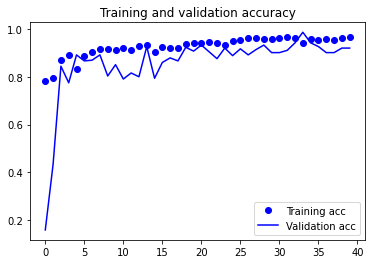

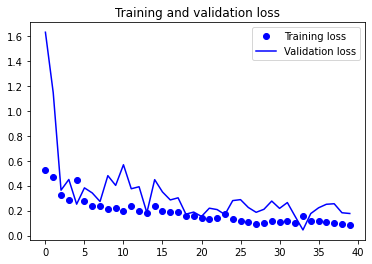

In [33]:
visualisation(model_2DCNNGRU)

On évalue le modèle :

In [34]:
evaluation(150, 2, model_2DCNNGRU)

10/10 [==============================] - 5s 426ms/step - loss: 0.0971 - acc: 0.9467
[[149   1]
 [ 15 135]]
10/10 [==============================] - 2s 184ms/step - loss: 0.1030 - acc: 0.9533
[[147   3]
 [ 11 139]]


## Modèle 2 : 3DCNN

In [69]:
my_callbacks2 = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        min_delta = 0,
        patience = 15,
        verbose = 1,
        restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/model_3DCNN.h5')
]

In [70]:
model_3DCNN = action_model_3DCNN(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model_3DCNN.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
model_3DCNN.fit(Data, Y, epochs=EPOCH, validation_split=0.2, batch_size=BS, callbacks=my_callbacks2)

On sauvegarde le modèle avec les meilleurs poids : 

In [ ]:
model_3DCNN_saved = model_3DCNN.load_weights("/tmp/model_3DCNN.h5")

In [ ]:
visualisation(model_3DCNN)

On évalue le modèle

In [ ]:
evaluation(150, 2, model_3DCNN)

Le modèle est plus efficace que les modèles 2D, il prédit avec une accuracy de ...% sur un jeu de séquences aléatoires en test.

## Modèle 2 : 3DCNN + autre pre-processing

Afin d'obtenir des résultats encore meilleurs nous  avons amélioré les techniques de pre-processing, nous choisissons donc les fichiers hdf5 correspondant à ces nouvelles méthodes pour l'apprentissage.

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.2.hdf5",
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.2.hdf5")
labelling(Dataset)

In [17]:
my_callbacks3 = [
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/model_3DCNN2.h5', monitor="val_acc"),
    tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_acc',
        min_delta = 0,
        patience = 15,
        verbose = 1,
        restore_best_weights = True)
    ]

In [ ]:
model_3DCNN2 = action_model_3DCNN(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model_3DCNN2.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
model_3DCNN2.fit(Data, Y, epochs=EPOCH, validation_split=0.2, batch_size=BS, callbacks=my_callbacks3)

On sauvegarde le modèle avec les meilleurs poids :

In [ ]:
model_3DCNN2_saved = model_3DCNN2.load_weights("/tmp/model_3DCNN2.h5")

On évalue le modèle :

In [ ]:
evaluation(150, 2, model_3DCNN2)